In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from numpy import sqrt
import time

import capytaine as cpt
from capytaine_generator import CapytaineSlantSolver

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

import pickle

In [2]:
with open("data/pseudo-slant-3.pkl", "rb") as f:
  configurations = pickle.load(f)

In [3]:
# Different versions of approximating slant with staircase

# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

# staircase with outlines through centers, starting vertical, end horizontal
def make_slant_region3(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (0.5 + i) * delta_d)
  return a_prime, d_prime


# produces variables for approximating MEEM config
def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  elif version == 3:
     make_slant_region = make_slant_region3
  else:
     raise ValueError

  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime

# Specifically for our 2-region case
def solve_prob(config, res, version, nmk):
  NMK = [nmk, nmk, nmk]
  a, d_in, d_out, heaving = config["a"], config["d_in"], config["d_out"], config["heaving"]
  d_prime, a_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = Problem(config["h"], d_prime, a_prime, heaving_prime, NMK_prime, config["m0"], config["rho"])
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  return prob, x

In [4]:
print(configurations[5]["CPT slant AM"])
print(configurations[5]["MEEM approx AMs"][-1])
print(configurations[5]["CPT slant DP"])
print(configurations[5]["MEEM approx DPs"][-1])

126168.07523282901
164644.0212019969
1.1634661269339492
1.6044508215821542


In [6]:
# res = 25
# 151443.49254992633 0.684381843842924 #100
# 144995.01272613535 0.7716946527195514 #150
# 143306.40643072198 0.8187600584546425 #200

# res = 30
# 150105.30332435854 0.7251319748360456 #100
# 143438.38064542963 0.7957079263846585 #150
# 141244.9699772406 0.8530128436135318 #200

# res = 40
# 142347.39483047955 0.8350149126044754 #150
# 138823.2579015579 0.8813699786600745 #200

# res = 50
# 138209.9936253744 0.9020630235519791 # 200
# 136068.2543071937 0.9323700378884833 #250

In [5]:
config = configurations[5]
resolutions = list(range(1, 51))
# am_array = []
# dp_array = []
# for res in resolutions:
#   prob, x = solve_prob(config, res, 3, 2) # version 3, terms/region = 2
#   am, dp = prob.hydro_coeffs(x, "capytaine")
#   ams = [am]
#   dps = [dp]
#   for terms in range(3, 101):
#     prob, x = solve_prob(config, res, 3, terms)
#     am, dp = prob.hydro_coeffs(x, "capytaine")
#     ams.append(am)
#     dps.append(dp)
#   am_array.append(ams)
#   dp_array.append(dps)

# with open("data/pseudo-slant-4-convergence.pkl", "wb") as f:
#   pickle.dump({"AMs" : am_array,
#                "DPs" : dp_array}, f)

with open("data/pseudo-slant-4-convergence.pkl", "rb") as f:
  data = pickle.load(f)
am_array = data["AMs"]
dp_array = data["DPs"]

In [ ]:
def plot_multiple_fade(x, ys, colors = ["Reds", "Greens", "Blues"], labs = None, last_k = None, title = "plot", xlab = "x", ylab = "y", hline = None, hlab = None):
    if hline is not None:
      plt.axhline(y = hline, color='orange', label = hlab)

    if type(ys[0][0]) != list:
       ys = [ys]

    if labs is None or type(labs[0]) != list:
       labs = [labs]

    for i in range(len(ys)):
      plot_fade(x, ys[i], labs[i], last_k, colors[i])

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_fade(x, ys, labs = None, last_k = None, cname = "Blue"):
  if labs is None:
      labs = [None] * len(ys)

  if last_k is not None: # get rid of early extreme values for scaling
      x = x[-last_k:]
      ys = [y[-last_k:] for y in ys]

  cmap = get_cmap(cname)
  color_vals = np.linspace(0.8, 0.2, len(ys))

  for y, label, color_val in zip(ys, labs, color_vals):
        plt.plot(x, y, label = label, color=cmap(color_val))

def make_label(num_lst, key):
  return [key + " = " + str(num) for num in num_lst]

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2014413023.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2014413023.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


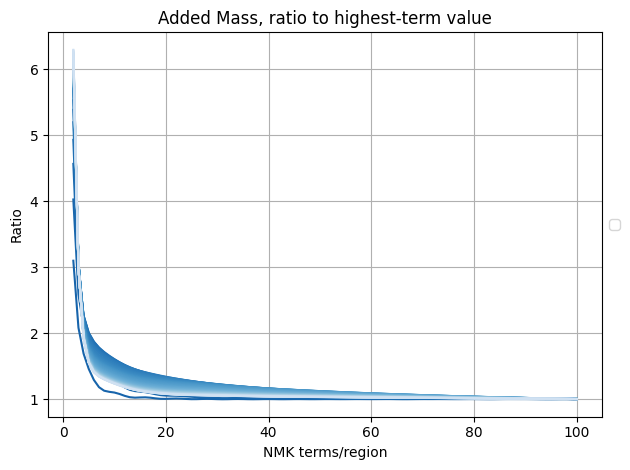

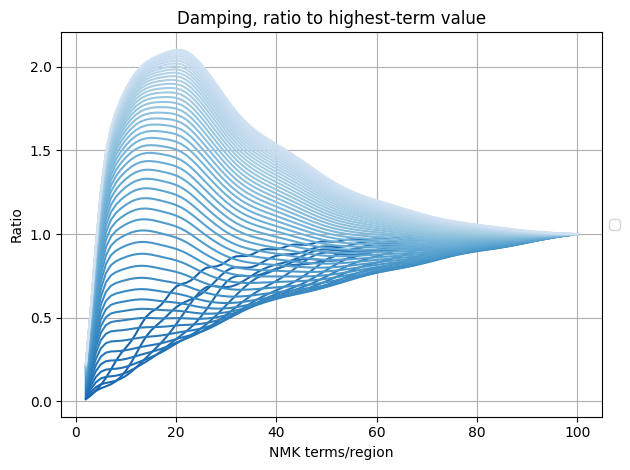

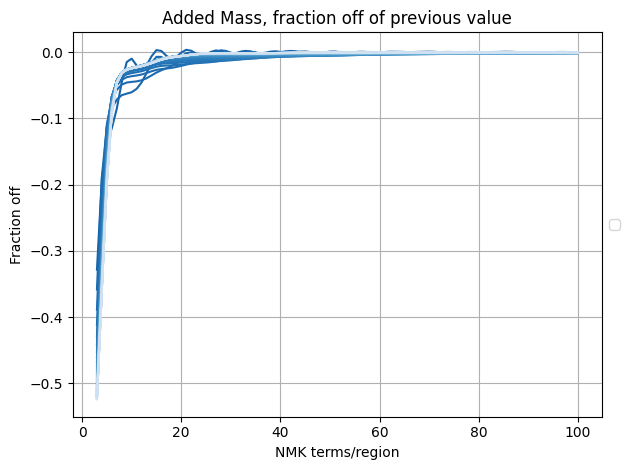

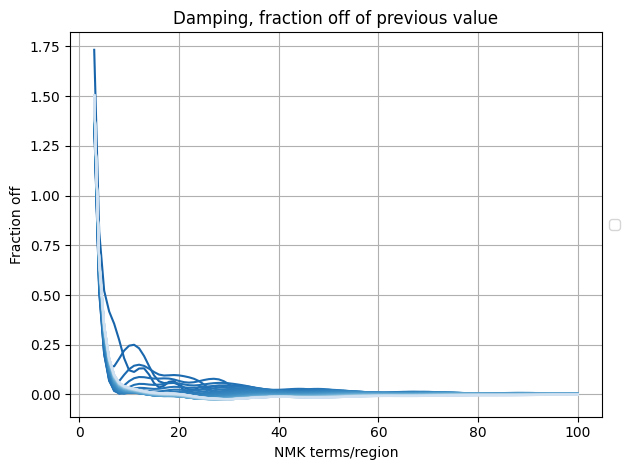

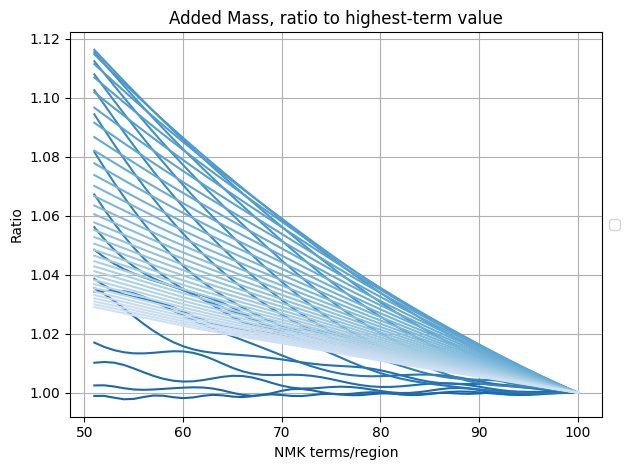

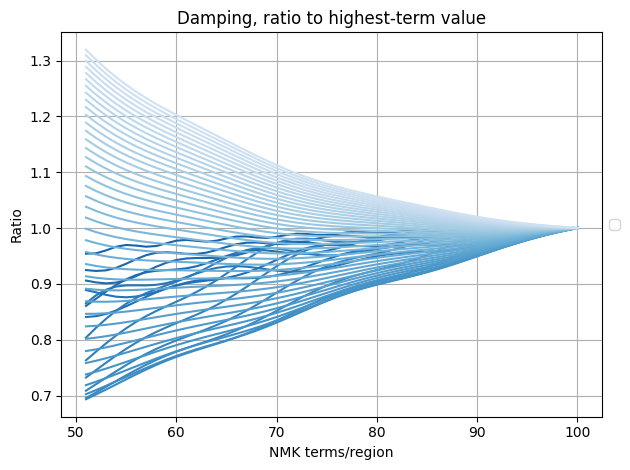

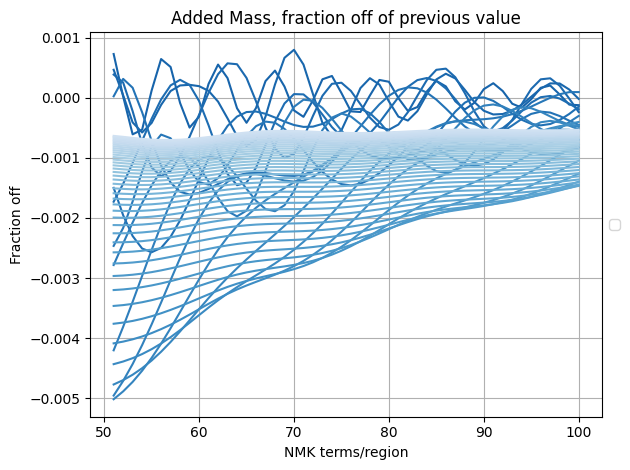

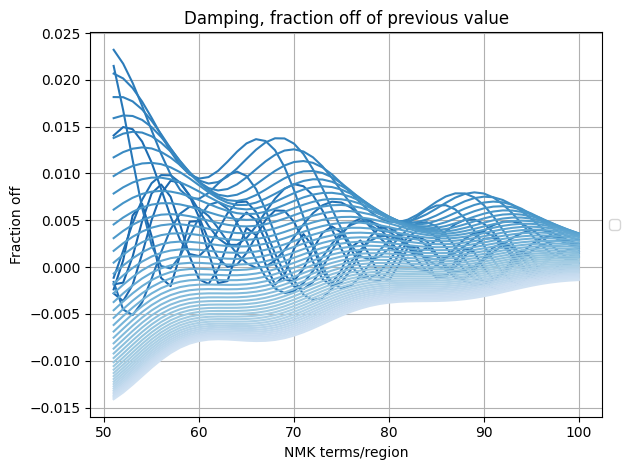

In [9]:

labs = make_label(resolutions, "res")

def ratio_conversion(arr):
  return [[value / row[-1] for value in row] for row in arr]

def percent_off(arr):
    return [
        [((row[j] / row[j - 1]) - 1) for j in range(1, len(row))]
        for row in arr
    ]

am_ratio_arr = ratio_conversion(am_array)
dp_ratio_arr = ratio_conversion(dp_array)

am_percent_diff_arr = percent_off(am_array)
dp_percent_diff_arr = percent_off(dp_array)


plot_multiple_fade(list(range(2, 101)), am_ratio_arr, labs = None, title = "Added Mass, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio", colors = ["Blues"])
plot_multiple_fade(list(range(2, 101)), dp_ratio_arr, labs = None, title = "Damping, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio", colors = ["Blues"])
plot_multiple_fade(list(range(3, 101)), am_percent_diff_arr, labs = None, title = "Added Mass, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off", colors = ["Blues"])
plot_multiple_fade(list(range(3, 101)), dp_percent_diff_arr, labs = None, title = "Damping, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off", colors = ["Blues"])
plot_multiple_fade(list(range(2, 101)), am_ratio_arr, labs = None, last_k = 50, title = "Added Mass, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio", colors = ["Blues"])
plot_multiple_fade(list(range(2, 101)), dp_ratio_arr, labs = None, last_k = 50, title = "Damping, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio", colors = ["Blues"])
plot_multiple_fade(list(range(3, 101)), am_percent_diff_arr, labs = None, last_k = 50, title = "Added Mass, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off", colors = ["Blues"])
plot_multiple_fade(list(range(3, 101)), dp_percent_diff_arr, labs = None, last_k = 50, title = "Damping, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off", colors = ["Blues"])

In [10]:
def update_data_file(data, name):
  with open(name, "wb") as f:
    pickle.dump(data, f)

In [11]:
config = configurations[5]
res = 50
# am_lst = am_array[-1].copy()
# dp_lst = dp_array[-1].copy()

# for terms in range(101, 301):
#   prob, x = solve_prob(config, res, 3, terms)
#   am, dp = prob.hydro_coeffs(x, "capytaine")
#   am_lst.append(am)
#   dp_lst.append(dp)
#   update_data_file({"AMs" : am_lst, "DPs" : dp_lst}, "data/pseudo-slant-4-res-50.pkl")
#   print("Finished NMK = " + str(terms))

with open("data/pseudo-slant-4-res-50.pkl", "rb") as f:
  data = pickle.load(f)
am_lst = data["AMs"]
dp_lst = data["DPs"]

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2014413023.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


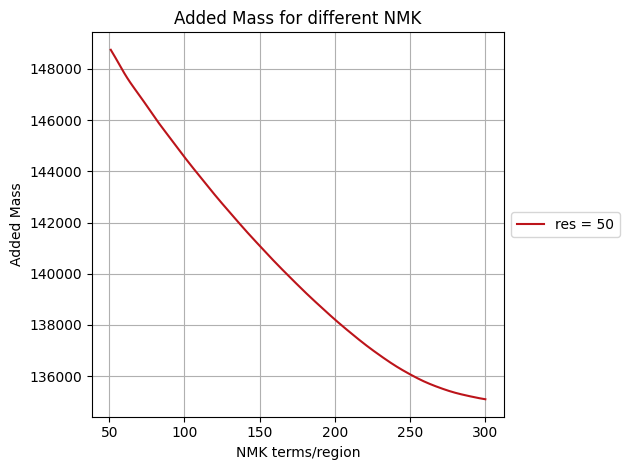

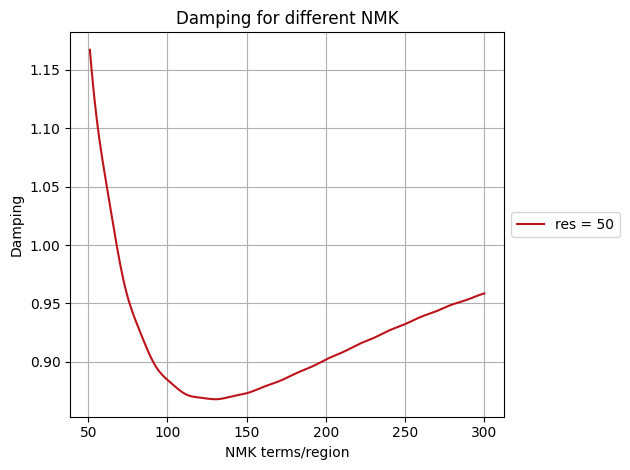

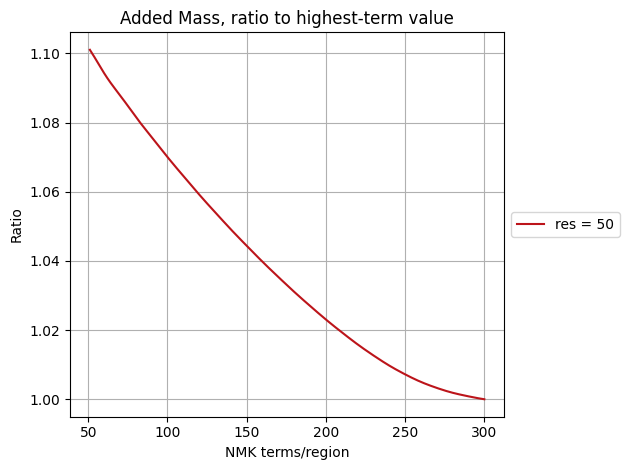

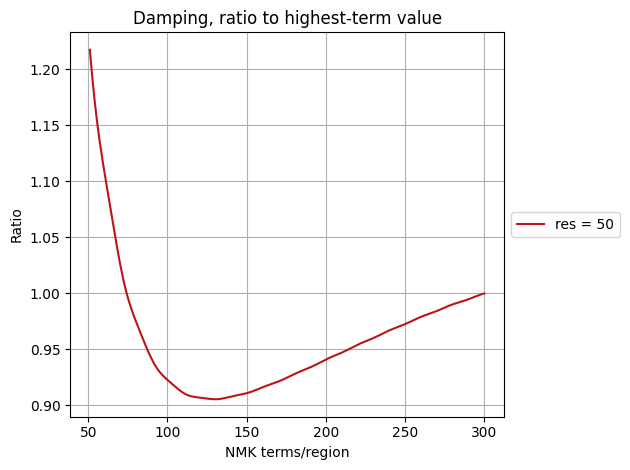

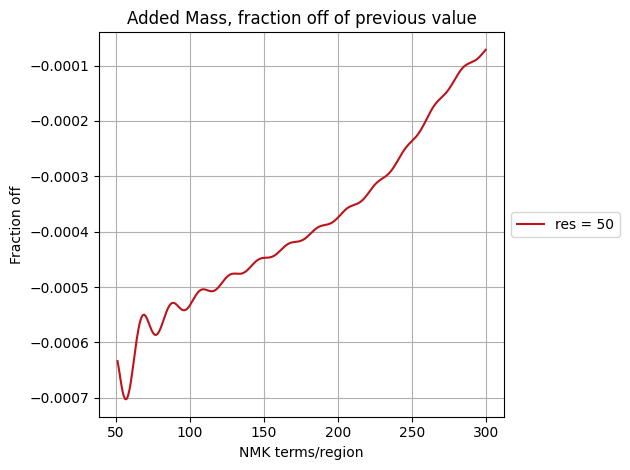

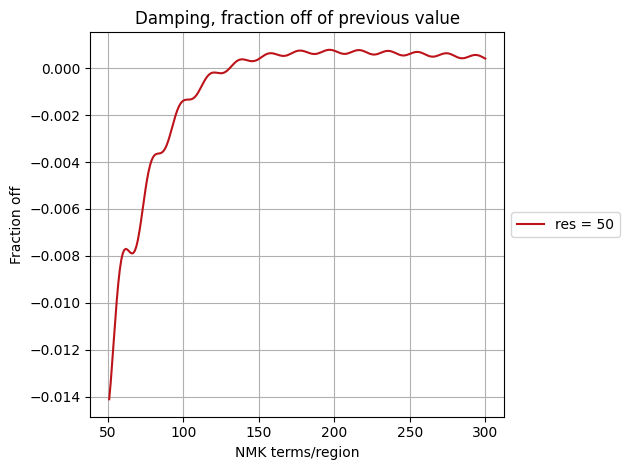

In [12]:
am_ratios = ratio_conversion([am_lst])
dp_ratios = ratio_conversion([dp_lst])

am_percent_diffs = percent_off([am_lst])
dp_percent_diffs = percent_off([dp_lst])

plot_multiple_fade(list(range(2, 301)), [am_lst], labs = ["res = 50"], last_k = 250, title = "Added Mass for different NMK",
                   xlab = "NMK terms/region", ylab = "Added Mass")
plot_multiple_fade(list(range(2, 301)), [dp_lst], labs = ["res = 50"], last_k = 250, title = "Damping for different NMK",
                   xlab = "NMK terms/region", ylab = "Damping")
plot_multiple_fade(list(range(2, 301)), am_ratios, labs = ["res = 50"], last_k = 250, title = "Added Mass, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(2, 301)), dp_ratios, labs = ["res = 50"], last_k = 250, title = "Damping, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(2, 301)), am_percent_diffs, labs = ["res = 50"], last_k = 250, title = "Added Mass, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")
plot_multiple_fade(list(range(2, 301)), dp_percent_diffs, labs = ["res = 50"], last_k = 250, title = "Damping, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2014413023.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


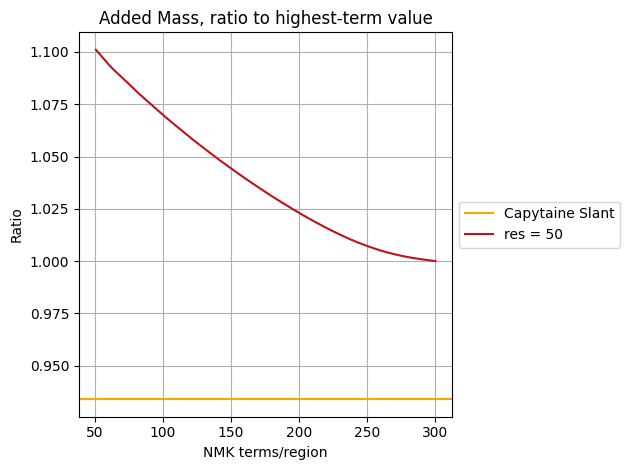

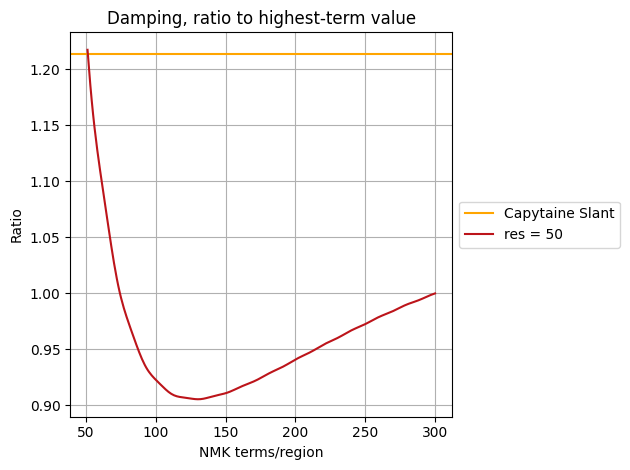

In [13]:
true_am_ratios = [entry/configurations[5]["CPT slant AM"] for entry in am_lst]
true_dp_ratios = [entry/configurations[5]["CPT slant DP"] for entry in dp_lst]

plot_multiple_fade(list(range(2, 301)), true_am_ratios, labs = ["res = 50"], last_k = 250, title = "Added Mass, ratio to Capytaine value",
                   xlab = "NMK terms/region", ylab = "Ratio", hline = 1, hlab = "Capytaine Slant")
plot_multiple_fade(list(range(2, 301)), true_dp_ratios, labs = ["res = 50"], last_k = 250, title = "Damping, ratio to Capytaine Value",
                   xlab = "NMK terms/region", ylab = "Ratio", hline = 1, hlab = "Capytaine Slant")

In [45]:
with open("data/ps4-all-configs-v1.pkl", "rb") as f:
  v1_set = pickle.load(f)
with open("data/ps4-all-configs-v2.pkl", "rb") as f:
  v2_set = pickle.load(f)
with open("data/ps4-all-configs-v3.pkl", "rb") as f:
  v3_set = pickle.load(f)

sets = [v1_set, v2_set, v3_set]

keys = ["AMs by res", "DPs by res", "AMs by nmk", "DPs by nmk"]

In [56]:
update_data_file(combined, "data/ps4-all-configs-res-nmk.pkl")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/4135650291.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


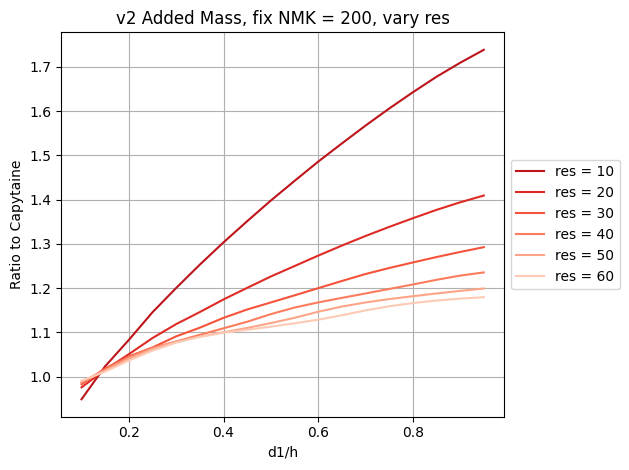

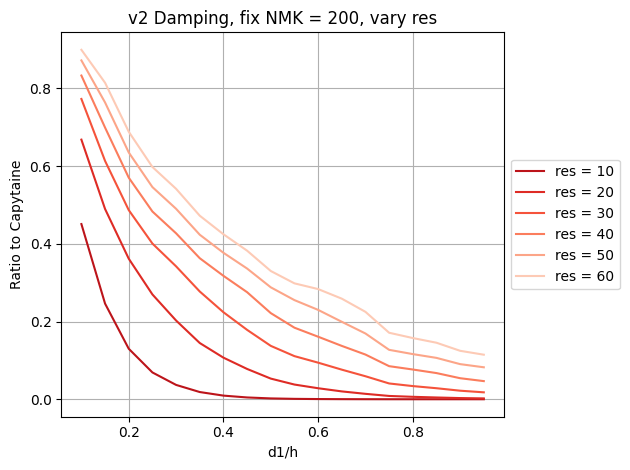

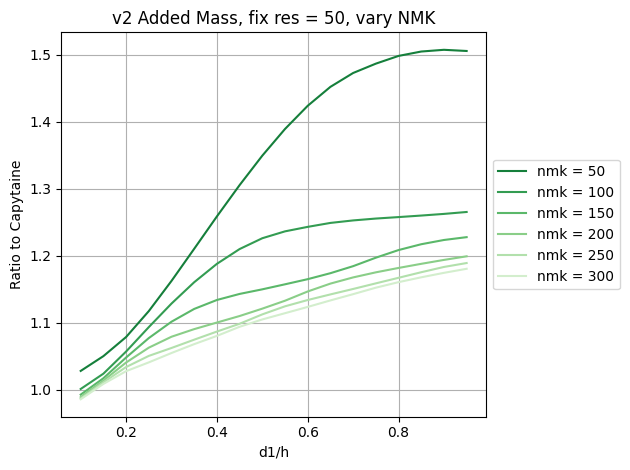

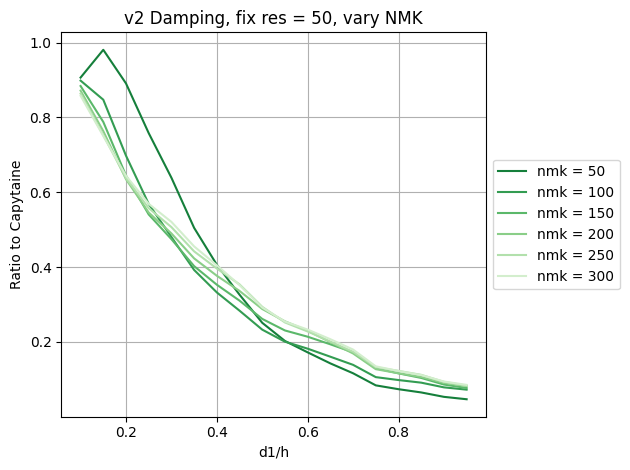

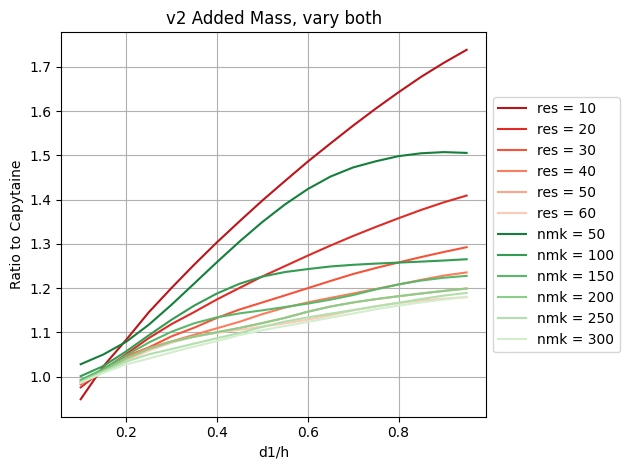

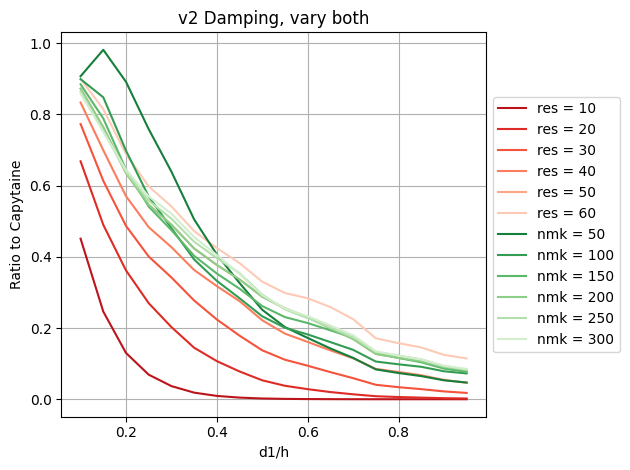

In [58]:
# Plot type 1
# x-axis: d1/h
# y-axis: ratio of MEEM hydro-coefficient to Capytaine's value.
# Fixed res, vary NMK in the different lines.
# Fixed NMK, vary res in the different lines.

with open("data/ps4-all-configs-res-nmk.pkl", "rb") as f:
  data = pickle.load(f)

version = 2

def extract(configurations, key, length):
  all_series = []
  for i in range(length):
    single_series = [config[key][i] for config in configurations]
    all_series.append(single_series)
  return all_series

def list_ratios(lst_of_lsts, base_lst):
  # Element i of each list  is expressed as a ratio to the the ith entry of base_lst
  output = []
  for lst in lst_of_lsts:
    output.append([lst[i]/base_lst[i] for i in range(len(base_lst))])
  return output

def plot_type_1(configurations, version):
  x = [entry/100 for entry in list(range(10, 96, 5))]
  resolutions = [10, 20, 30, 40, 50, 60]
  nmks = [50, 100, 150, 200, 250, 300]

  keys = ["AMs by res v" + str(version), "DPs by res v" + str(version), "AMs by nmk v" + str(version), "DPs by nmk v" + str(version)]
  hc_raw = [extract(configurations[1:], key, 6) for key in keys]

  ams_by_res_ratio = list_ratios(hc_raw[0], [config["CPT slant AM"] for config in configurations[1:]])
  dps_by_res_ratio = list_ratios(hc_raw[1], [config["CPT slant DP"] for config in configurations[1:]])
  ams_by_nmk_ratio = list_ratios(hc_raw[2], [config["CPT slant AM"] for config in configurations[1:]])
  dps_by_nmk_ratio = list_ratios(hc_raw[3], [config["CPT slant DP"] for config in configurations[1:]])

  res_labs = make_label(resolutions, "res")
  nmk_labs = make_label(nmks, "nmk")

  plot_multiple_fade(x, [ams_by_res_ratio], labs = res_labs, title = "v" + str(version) + " Added Mass, fix NMK = 200, vary res",
                    xlab = "d1/h", ylab = "Ratio to Capytaine")
  plot_multiple_fade(x, [dps_by_res_ratio], labs = res_labs, title = "v" + str(version) + " Damping, fix NMK = 200, vary res",
                    xlab = "d1/h", ylab = "Ratio to Capytaine")
  plot_multiple_fade(x, [ams_by_nmk_ratio], labs = nmk_labs, title = "v" + str(version) + " Added Mass, fix res = 50, vary NMK",
                    xlab = "d1/h", ylab = "Ratio to Capytaine", colors = ["Greens"])
  plot_multiple_fade(x, [dps_by_nmk_ratio], labs = nmk_labs, title = "v" + str(version) + " Damping, fix res = 50, vary NMK",
                    xlab = "d1/h", ylab = "Ratio to Capytaine", colors = ["Greens"])
  plot_multiple_fade(x, [ams_by_res_ratio, ams_by_nmk_ratio], labs = [res_labs, nmk_labs], title = "v" + str(version) + " Added Mass, vary both",
                    xlab = "d1/h", ylab = "Ratio to Capytaine")
  plot_multiple_fade(x, [dps_by_res_ratio, dps_by_nmk_ratio], labs = [res_labs, nmk_labs], title = "v" + str(version) + " Damping, vary both",
                    xlab = "d1/h", ylab = "Ratio to Capytaine")
  
plot_type_1(data, version)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/4135650291.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


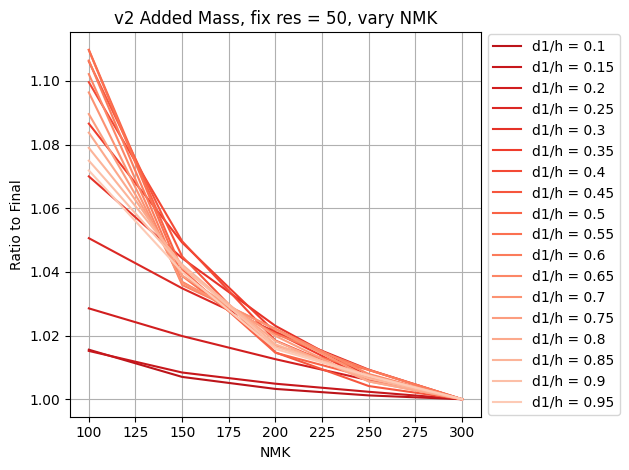

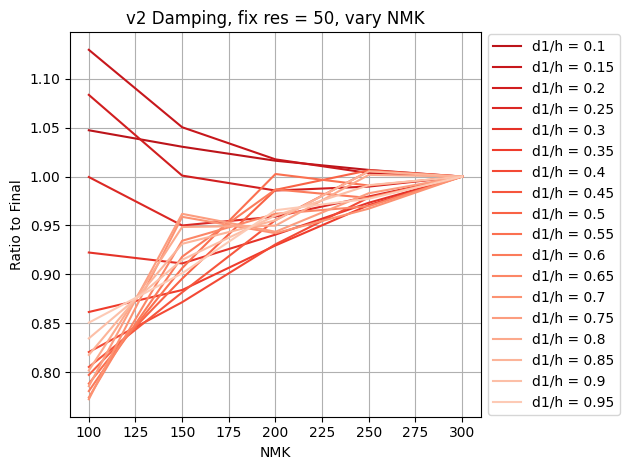

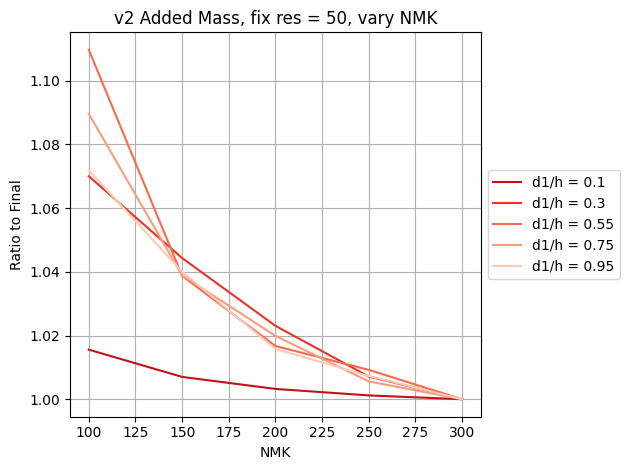

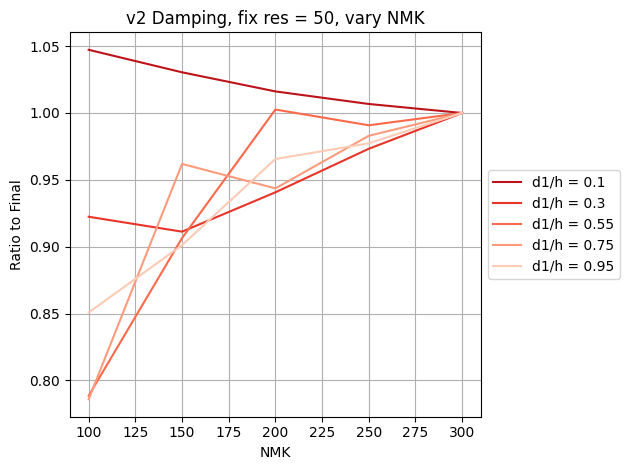

In [59]:
# Plot type 2 (Typical MEEM convergence-study style)
# x-axis: nmk
# y-axis: ratio of hydro-coefficient to final value.
# Fixed res, vary configuration in the different lines.

def transpose(matrix):
    return [list(row) for row in zip(*matrix)]

def select(lst_of_lsts, indices):
    return [[lst[i] for i in indices] for lst in lst_of_lsts]

def plot_type_2(configurations, version):
    keys = ["AMs by res v" + str(version), "DPs by res v" + str(version), "AMs by nmk v" + str(version), "DPs by nmk v" + str(version)]
    hc_raw = [extract(configurations[1:], key, 6) for key in keys]

    x = [50, 100, 150, 200, 250, 300]
    d1h = [entry/100 for entry in list(range(10, 96, 5))]
    d1h_labs = make_label(d1h, "d1/h")

    final_values = [([config[key][-1] for config in configurations[1:]]) for key in keys]

    ams_by_config_nmk_ratio = transpose(list_ratios(hc_raw[2], final_values[2]))
    dps_by_config_nmk_ratio = transpose(list_ratios(hc_raw[3], final_values[3]))

    plot_multiple_fade(x, [ams_by_config_nmk_ratio], labs = d1h_labs, title = "v" + str(version) + " Added Mass, fix res = 50, vary NMK",
                    xlab = "NMK", ylab = "Ratio to Final", last_k = 5)
    plot_multiple_fade(x, [dps_by_config_nmk_ratio], labs = d1h_labs, title = "v" + str(version) + " Damping, fix res = 50, vary NMK",
                    xlab = "NMK", ylab = "Ratio to Final", last_k = 5)

    ys0, labs0 = select([ams_by_config_nmk_ratio, d1h_labs], [0, 4, 9, 13, 17])
    plot_multiple_fade(x, [ys0], labs = labs0, title = "v" + str(version) + " Added Mass, fix res = 50, vary NMK",
                    xlab = "NMK", ylab = "Ratio to Final", last_k = 5)
    ys0, labs0 = select([dps_by_config_nmk_ratio, d1h_labs], [0, 4, 9, 13, 17])
    plot_multiple_fade(x, [ys0], labs = labs0, title = "v" + str(version) + " Damping, fix res = 50, vary NMK",
                    xlab = "NMK", ylab = "Ratio to Final", last_k = 5)
    
plot_type_2(data, version)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2305052013.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


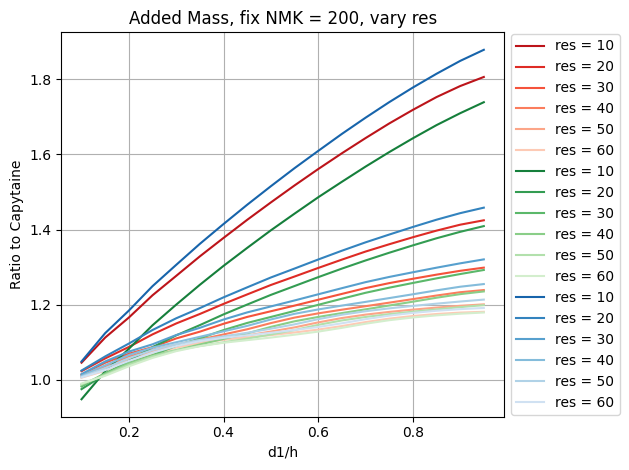

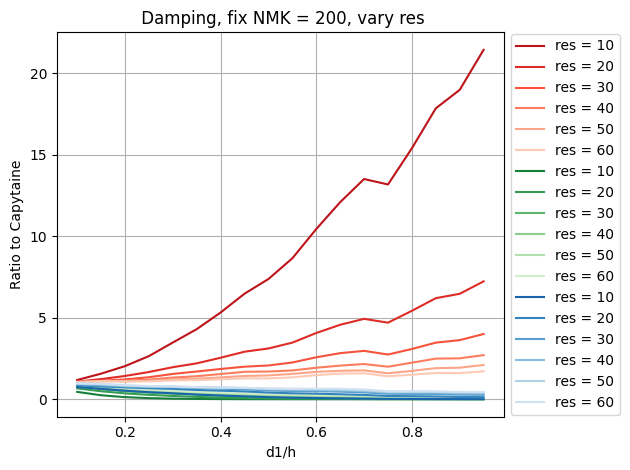

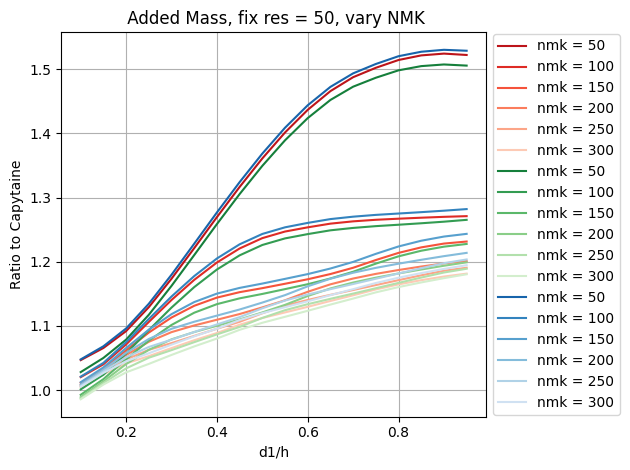

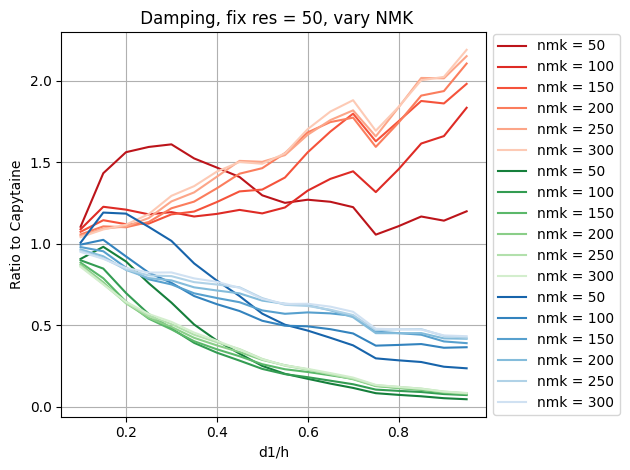

In [79]:
with open("data/ps4-all-configs-v1.pkl", "rb") as f:
  configurations1 = pickle.load(f)
with open("data/ps4-all-configs-v2.pkl", "rb") as f:
  configurations2 = pickle.load(f)
with open("data/ps4-all-configs-v3.pkl", "rb") as f:
  configurations3 = pickle.load(f)

x = [entry/100 for entry in list(range(10, 96, 5))]
resolutions = [10, 20, 30, 40, 50, 60]
nmks = [50, 100, 150, 200, 250, 300]

keys = ["AMs by res", "DPs by res", "AMs by nmk", "DPs by nmk"]
hc_raw123 = [[extract(data[1:], key + " v" + str(version), 6) for key in keys] for version in [1, 2, 3]]

ams_by_res_ratios = [list_ratios(hc_raw[0], [config["CPT slant AM"] for config in data[1:]]) for hc_raw in hc_raw123]
dps_by_res_ratios = [list_ratios(hc_raw[1], [config["CPT slant DP"] for config in data[1:]]) for hc_raw in hc_raw123]
ams_by_nmk_ratios = [list_ratios(hc_raw[2], [config["CPT slant AM"] for config in data[1:]]) for hc_raw in hc_raw123]
dps_by_nmk_ratios = [list_ratios(hc_raw[3], [config["CPT slant DP"] for config in data[1:]]) for hc_raw in hc_raw123]

res_labs = make_label(resolutions, "res")
nmk_labs = make_label(nmks, "nmk")

plot_multiple_fade(x, ams_by_res_ratios, labs = res_labs, title = "Added Mass, fix NMK = 200, vary res",
                  xlab = "d1/h", ylab = "Ratio to Capytaine")
plot_multiple_fade(x, dps_by_res_ratios, labs = res_labs, title = " Damping, fix NMK = 200, vary res",
                  xlab = "d1/h", ylab = "Ratio to Capytaine")
plot_multiple_fade(x, ams_by_nmk_ratios, labs = nmk_labs, title = " Added Mass, fix res = 50, vary NMK",
                  xlab = "d1/h", ylab = "Ratio to Capytaine")
plot_multiple_fade(x, dps_by_nmk_ratios, labs = nmk_labs, title = " Damping, fix res = 50, vary NMK",
                  xlab = "d1/h", ylab = "Ratio to Capytaine")

18
5
3 18 5
3 18 5


/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2153883345.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2153883345.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_49998/2153883345.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


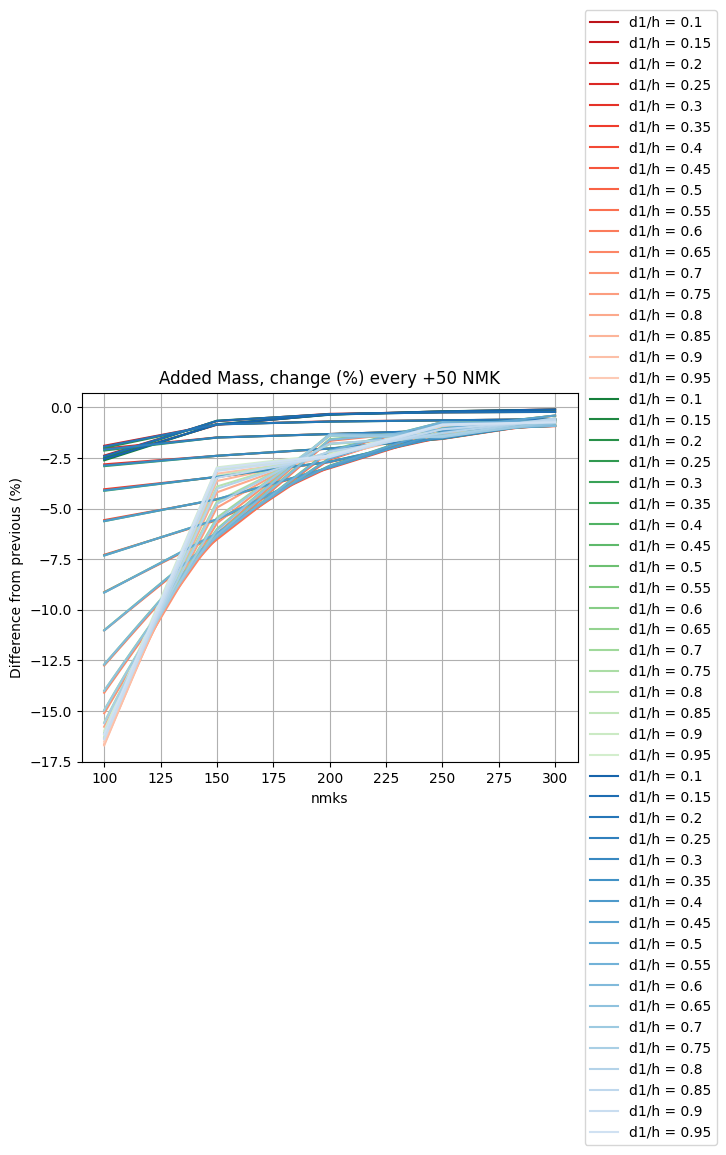

3 18 5


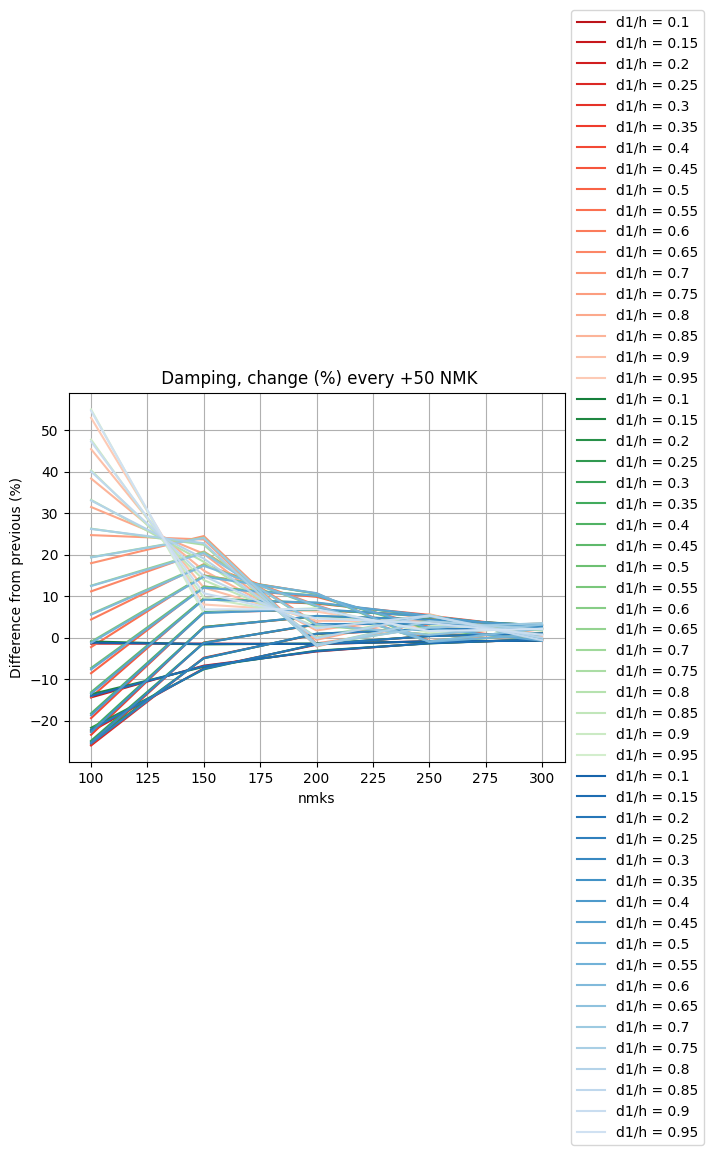

In [94]:
x = nmks[1:]

keys = ["AMs by res", "DPs by res", "AMs by nmk", "DPs by nmk"]
hc_raw123 = [[extract(data[1:], key + " v" + str(version), 6) for key in keys] for version in [1, 2, 3]]
ratios = [[[[(cf[i]/cf[i-1] - 1) * 100 for i in range(1, 6)] for cf in transpose(key)] for key in version] for version in hc_raw123]

ams_by_nmk_ratios = [ratios[version - 1][2] for version in [1, 2, 3]]
dps_by_nmk_ratios = [ratios[version - 1][3] for version in [1, 2, 3]]

res_labs = make_label(resolutions, "res")
nmk_labs = make_label(nmks, "nmk")
d1h_labs = make_label([entry/100 for entry in list(range(10, 96, 5))], "d1/h")

print(len(d1h_labs))
print(len(x))
print(len(ams_by_nmk_ratios), len(ams_by_nmk_ratios[0]), len(ams_by_nmk_ratios[0][0]))

plot_multiple_fade(x, ams_by_nmk_ratios, labs = d1h_labs, title = "Added Mass, change (%) every +50 NMK",
                  xlab = "nmks", ylab = "Difference from previous (%)")
plot_multiple_fade(x, dps_by_nmk_ratios, labs = d1h_labs, title = " Damping, change (%) every +50 NMK",
                  xlab = "nmks", ylab = "Difference from previous (%)")

In [19]:
# Let's try NMK = 200, res = 100, d1 = 80 (config [15])
config0 = configurations[15]
prob, x = solve_prob(config0, 100, 2, 250)
am, dp = prob.hydro_coeffs(x, "capytaine")

# am = 78257.44678678965, dp = 0.04822444146443415 for res = 100, NMK = 200


: 

In [8]:
print(am / 69407.45434426554, dp / 0.17936968315739565)
print(am, dp)


1.1275078091558806 0.2688550295431895
78257.44678678965 0.04822444146443415


In [ ]:
# 69296.94280312925 69407.45434426554
# 0.12071785020108175 0.17936968315739565

In [ ]:
# Have data for res = [10, 20, 30, 40, 50, 60] with NMK = 200
# Have data for NMK = [50, 100, 150, 200, 250, 300] with res = 50
# Want data for res = [40, 50, 60, 70], NMK = [50, 100, 150, 200, 250, 300]
# Need to compute data for:
# NMK = [50, 100, 150, 250, 300] for res = 40, 60
# NMK = [50, 100, 150, 200, 250, 300], res = 70
# d1 = 80 (config [15]). Do v2 (looks the nicest for AM)

# data_dict = {}
# config0 = configurations[15]
# for res in [40, 60]:
#   for nmk in [250]: # [300]
#     prob, x = solve_prob(config0, res, 2, nmk)
#     am, dp = prob.hydro_coeffs(x, "capytaine")
#     data_dict[str(res) + "-" + str(nmk) + " AM"] = am
#     data_dict[str(res) + "-" + str(nmk) + " DP"] = dp
#     update_data_file(data_dict, "data/ps4-res-nmk-grid.pkl")
# for res in [70]:
#   for nmk in [250]: # [300]
#     prob, x = solve_prob(config0, res, 2, nmk)
#     am, dp = prob.hydro_coeffs(x, "capytaine")
#     data_dict[str(res) + "-" + str(nmk) + " AM"] = am
#     data_dict[str(res) + "-" + str(nmk) + " DP"] = dp
#     update_data_file(data_dict, "data/ps4-res-nmk-grid.pkl")



In [ ]:
with open("data/ps4-res-nmk-grid.pkl", "rb") as f:
  data_dict = pickle.load(f)
# Populate data from previous work:
# with open("data/ps4-all-configs-v2.pkl", "rb") as f:
#   configurations = pickle.load(f)
# con15 = configurations[15]

# # get the res = 50 data
# res = 50
# nmks = [50, 100, 150, 200, 250, 300]
# for i in range(6):
#   data_dict[str(res) + "-" + str(nmks[i]) + " AM"] = con15["AMs by nmk"][i]
#   data_dict[str(res) + "-" + str(nmks[i]) + " DP"] = con15["DPs by nmk"][i]

# # get the nmk = 200 data
# nmk = 200
# data_dict[str(40) + "-" + str(nmk) + " AM"] = con15["AMs by res"][3]
# data_dict[str(40) + "-" + str(nmk) + " DP"] = con15["DPs by res"][3]
# data_dict[str(60) + "-" + str(nmk) + " AM"] = con15["AMs by res"][5]
# data_dict[str(60) + "-" + str(nmk) + " DP"] = con15["DPs by res"][5]
# update_data_file(data_dict, "data/ps4-res-nmk-grid.pkl")

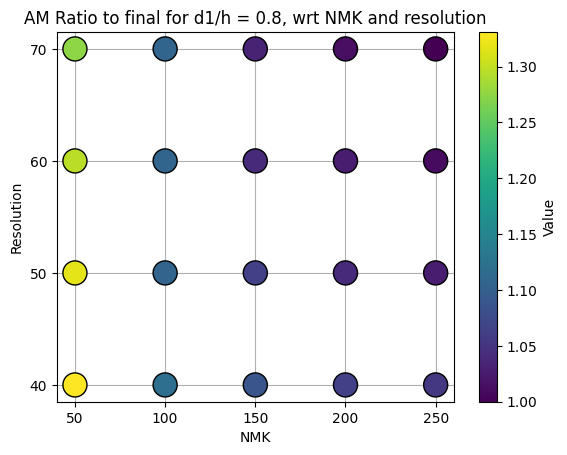

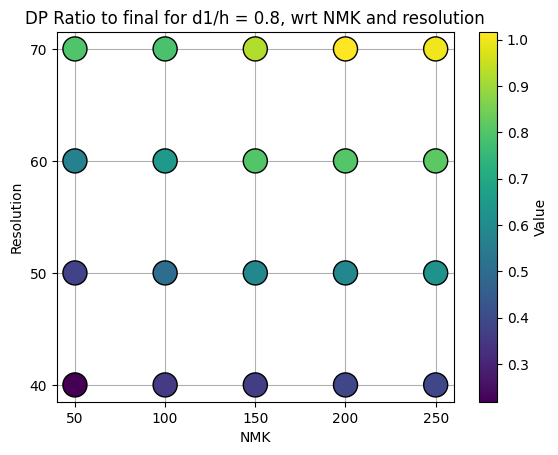

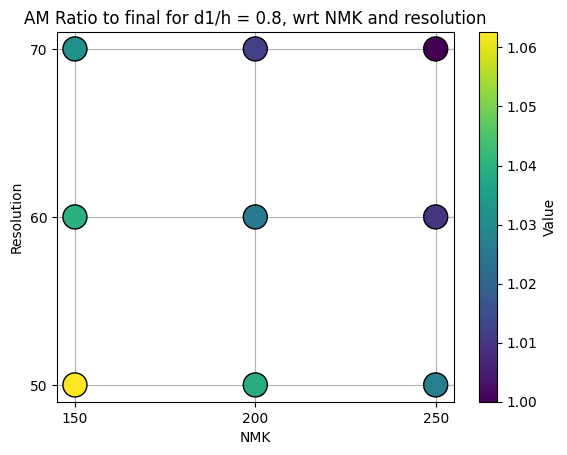

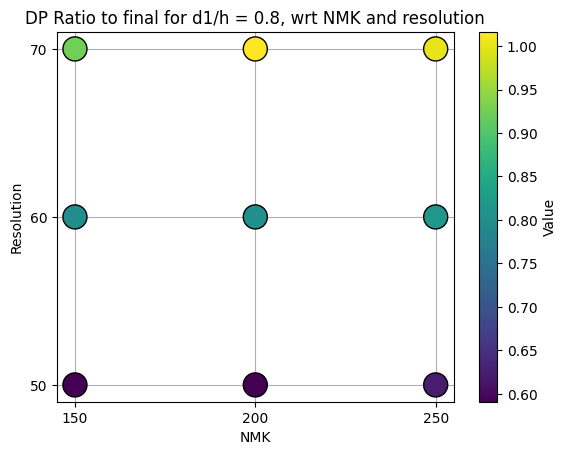

In [40]:
def plot_res_nmk_grid(coeff, data_dict, resolutions, nmks):

  data = [[data_dict[str(res) + "-" + str(nmk) + " " + coeff] for nmk in nmks] for res in resolutions]

  # Axis values
  x_vals = np.array(nmks)
  y_vals = np.array(resolutions)

  values = np.array(data)/(data[-1][-1]) # scale it
  

  # Create coordinate grid
  X, Y = np.meshgrid(x_vals, y_vals)

  # Flatten everything
  x_flat = X.flatten()
  y_flat = Y.flatten()
  val_flat = values.flatten()

  plt.grid(True, zorder=0)
  # Plot
  plt.scatter(x_flat, y_flat, c=val_flat, s=300, cmap='viridis', edgecolors='black', zorder=2)

  plt.colorbar(label='Value')
  plt.xlabel("NMK")
  plt.ylabel("Resolution")
  plt.title(coeff + " Ratio to final for d1/h = 0.8, wrt NMK and resolution")
  plt.xticks(x_vals)
  plt.yticks(y_vals)
  plt.show()

resolutions = [40, 50, 60, 70]
nmks = [50, 100, 150, 200, 250] # [50, 100, 150, 200, 250, 300] 

plot_res_nmk_grid("AM", data_dict, resolutions, nmks)
plot_res_nmk_grid("DP", data_dict, resolutions, nmks)
plot_res_nmk_grid("AM", data_dict, resolutions[1:], nmks[2:]) # Possibly more informative scaling.
plot_res_nmk_grid("DP", data_dict, resolutions[1:], nmks[2:])